In [2]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

import sys
import os
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (11,6),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [4]:
import torch
from sklearn.manifold import TSNE
import seaborn as sns

In [5]:
import pyarrow.dataset as ds
import pyarrow.feather as feather

In [138]:
from project.datasets import Dataset, CTRPDataModule
from project.models import ConditionalNetwork, StandardNetwork

In [7]:
def prepare(exp, subset=True):
    data_path = Path("../../film-gex-data/processed/")
    input_cols = joblib.load(data_path.joinpath("gene_cols.pkl"))
    
    if exp=='id':
        cpd_id = "master_cpd_id"
        cond_cols = np.array([cpd_id, 'cpd_conc_umol'])
    else:
        fp_cols = joblib.load(data_path.joinpath("fp_cols.pkl"))
        cond_cols = np.append(fp_cols, ['cpd_conc_umol'])
        
    if subset:
        dataset = ds.dataset(data_path.joinpath("train_sub.feather"), format='feather')
    else:
        dataset = ds.dataset(data_path.joinpath("train.feather"), format='feather')

    return dataset, input_cols, cond_cols

## Full Data Stats

In [10]:
# data_path = Path("../../film-gex-data/processed/")
# full_ds = ds.dataset(data_path.joinpath("train_sub.feather"), format='feather')
# full_data = full_ds.to_table().to_pandas()

In [11]:
# for c in full_data.columns: print(c, full_data[c].nunique())
# print(full_data.shape)
# del full_data

In [12]:
ds_path = Path("../../film-gex-data/drug_screens/")
ctrp = pd.read_csv(ds_path.joinpath("CTRP/v20.data.per_cpd_post_qc.txt") ,sep='\t', index_col=0)

/srv/home/wconnell/anaconda3/envs/lightning/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<AxesSubplot:xlabel='cpd_conc_umol'>

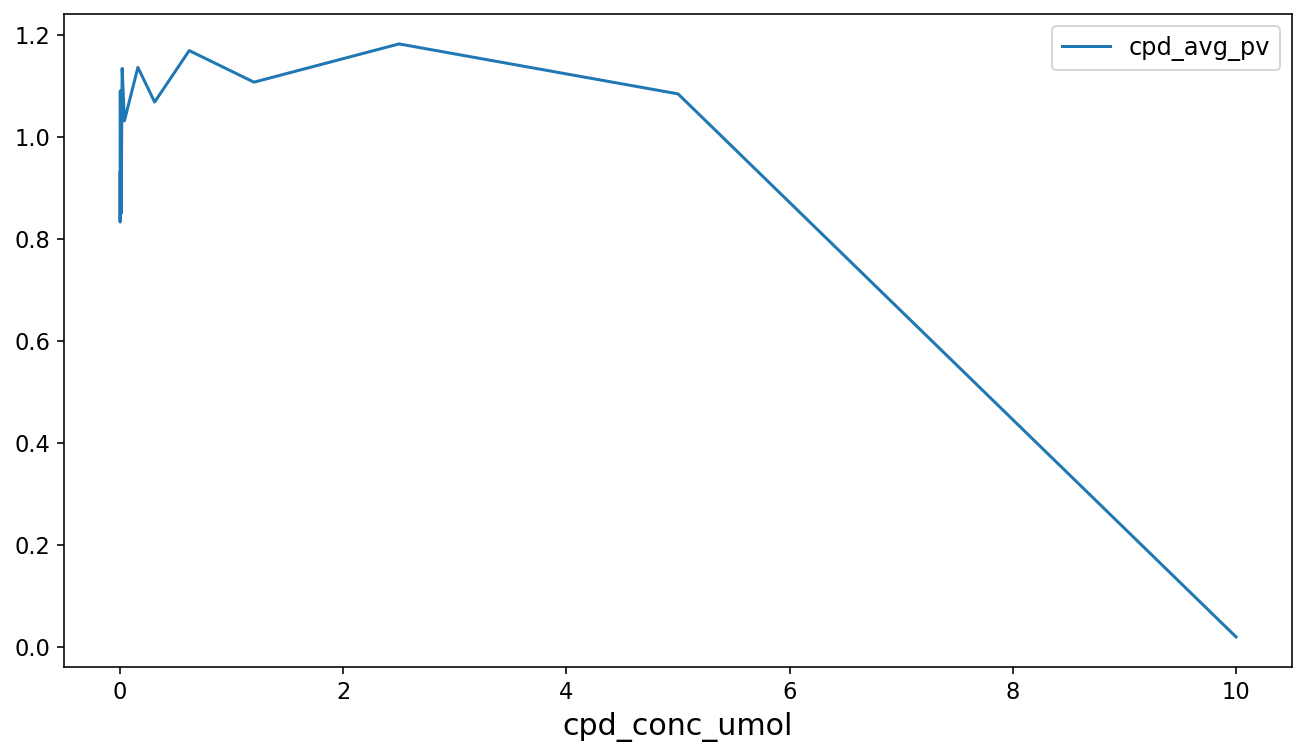

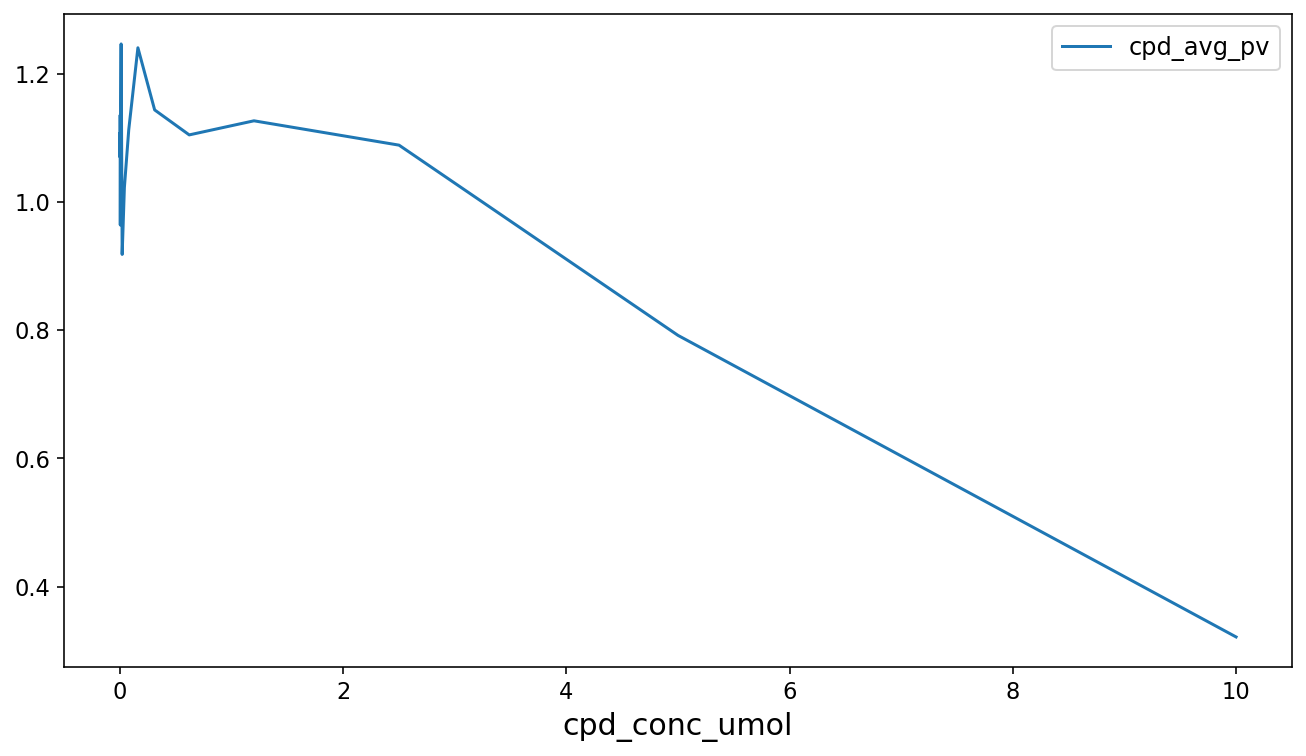

In [13]:
ctrp[ctrp['master_cpd_id']==1788].loc[1].plot('cpd_conc_umol', 'cpd_avg_pv')
ctrp[ctrp['master_cpd_id']==1788].loc[10].plot('cpd_conc_umol', 'cpd_avg_pv')

<AxesSubplot:xlabel='cpd_conc_umol'>

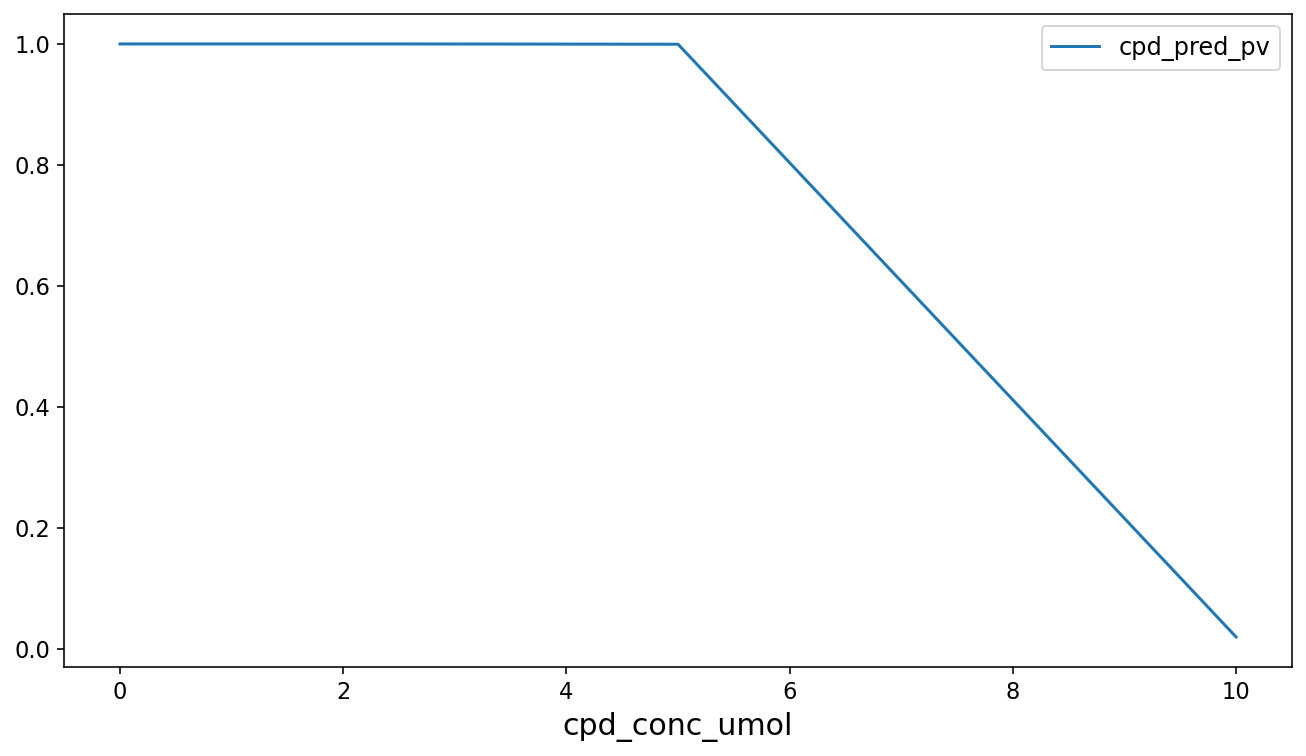

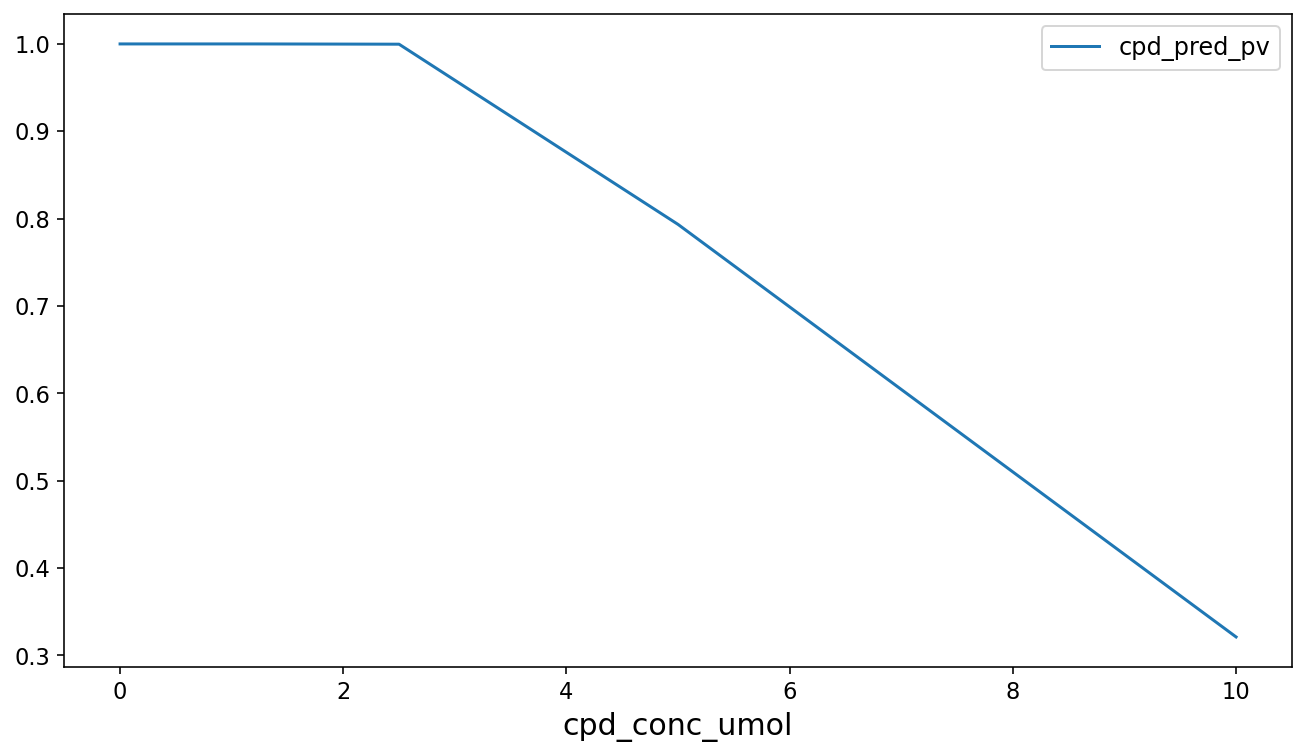

In [14]:
ctrp[ctrp['master_cpd_id']==1788].loc[1].plot('cpd_conc_umol', 'cpd_pred_pv')
ctrp[ctrp['master_cpd_id']==1788].loc[10].plot('cpd_conc_umol', 'cpd_pred_pv')

## Read Data

In [15]:
exp = 'film'
fold = 0

In [16]:
dataset, input_cols, cond_cols = prepare(exp, subset=True)
cols = list(np.concatenate((input_cols, cond_cols, ['cpd_pred_pv']))) 

In [17]:
train = dataset.to_table(columns=cols, filter=ds.field('fold') != fold).to_pandas()
val = dataset.to_table(columns=cols, filter=ds.field('fold') == fold).to_pandas()

In [18]:
dm = CTRPDataModule(train,
                    val,
                    input_cols,
                    cond_cols,
                    target='cpd_pred_pv',
                    batch_size=32768)

In [19]:
dm.setup(stage='fit')

(<project.datasets.TabularDataset at 0x7fb40aa9c7f0>,
 <project.datasets.TabularDataset at 0x7fb40aa9c760>)

##### MetaData

In [20]:
meta_data = dataset.to_table(columns=['master_cpd_id', 'cpd_conc_umol', 'cpd_pred_pv', 'cpd_avg_pv', 'stripped_cell_line_name'], filter=ds.field('fold') == fold).to_pandas()

In [21]:
meta_val_cpd = dataset.to_table(columns=['master_cpd_id', 'cpd_conc_umol', 'cpd_pred_pv', 'cpd_avg_pv'], filter=ds.field('fold') == fold).to_pandas()
meta_val_line = dataset.to_table(columns=['stripped_cell_line_name'], filter=ds.field('fold') == fold).to_pandas()

In [22]:
_, cpd_idx = np.unique(meta_val_cpd[['master_cpd_id', 'cpd_conc_umol']], return_index=True, axis=0)
meta_val_cpd = meta_val_cpd.iloc[cpd_idx, :].set_index('master_cpd_id')
meta_val_cpd['log_cpd_conc'] = np.log1p(meta_val_cpd['cpd_conc_umol'])

_, line_idx = np.unique(meta_val_line, return_index=True)
meta_val_line = meta_val_line.iloc[line_idx, :].set_index('stripped_cell_line_name')

In [23]:
print(meta_val_cpd.shape)
print(meta_val_line.shape)

(8852, 4)
(166, 0)


##### Compound target data

In [24]:
ds_path = Path("../../film-gex-data/drug_screens/")
cp_ctrp = pd.read_csv(ds_path.joinpath("CTRP/v20.meta.per_compound.txt"), sep="\t", index_col=0)

In [25]:
meta_val_cpd = meta_val_cpd.join(cp_ctrp)

In [26]:
from scipy.optimize import curve_fit
from scipy.stats import logistic

In [27]:
def ll4(x,b,c,d,e):
    '''This function is basically a copy of the LL.4 function from the R drc package with
     - b: hill slope
     - c: min response
     - d: max response
     - e: EC50'''
    return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))

Text(0.5, 1.0, 'Erlotinib')

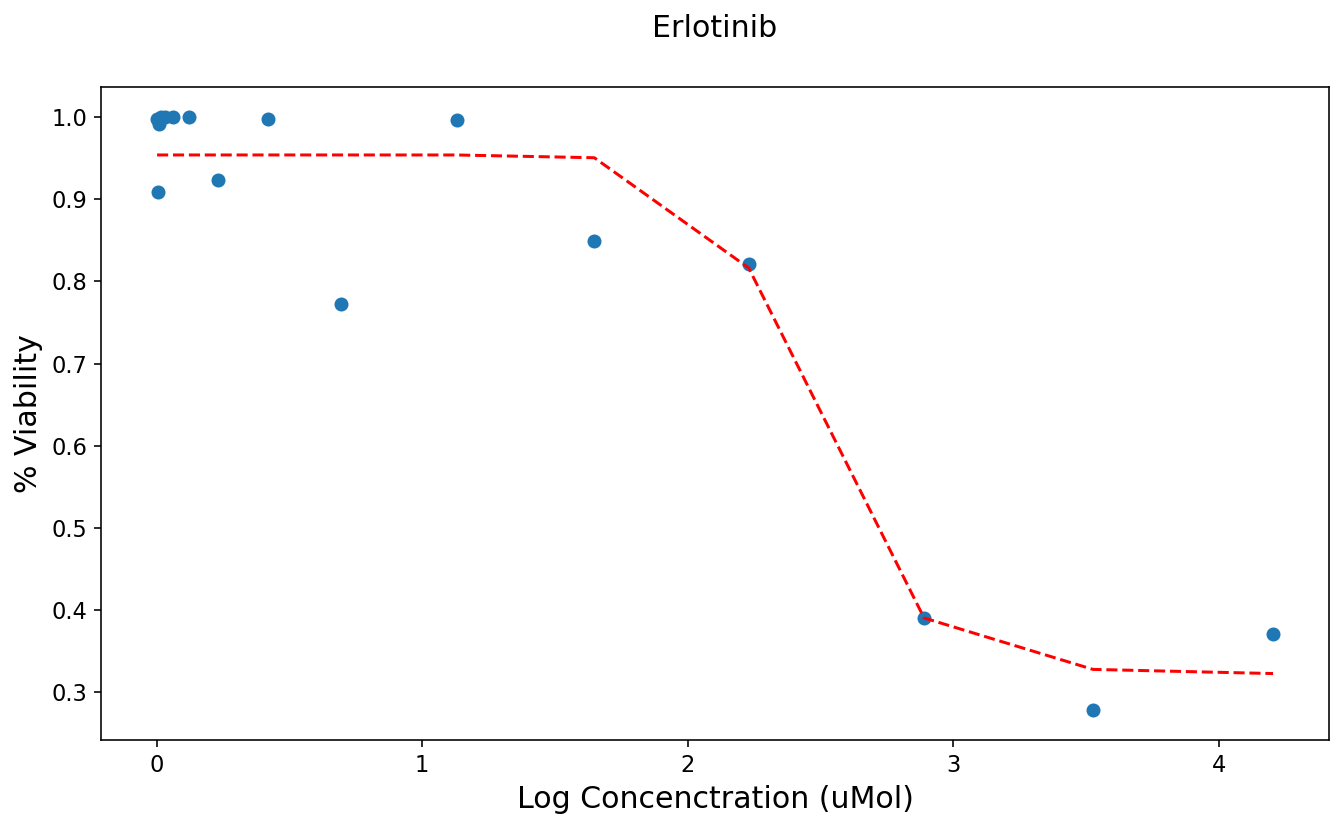

In [28]:
x = meta_val_cpd[meta_val_cpd['cpd_name']=='erlotinib']['log_cpd_conc'].values
y = meta_val_cpd[meta_val_cpd['cpd_name']=='erlotinib']['cpd_pred_pv'].values
popt, pcov = curve_fit(ll4, x, y)
plt.plot(x, y, ".", ms=12)
plt.plot(x, ll4(x, *popt), 'r--')

plt.xlabel('Log Concenctration (uMol)')
plt.ylabel('% Viability')
plt.title('Erlotinib')

Text(0.5, 1.0, 'Sirolimus')

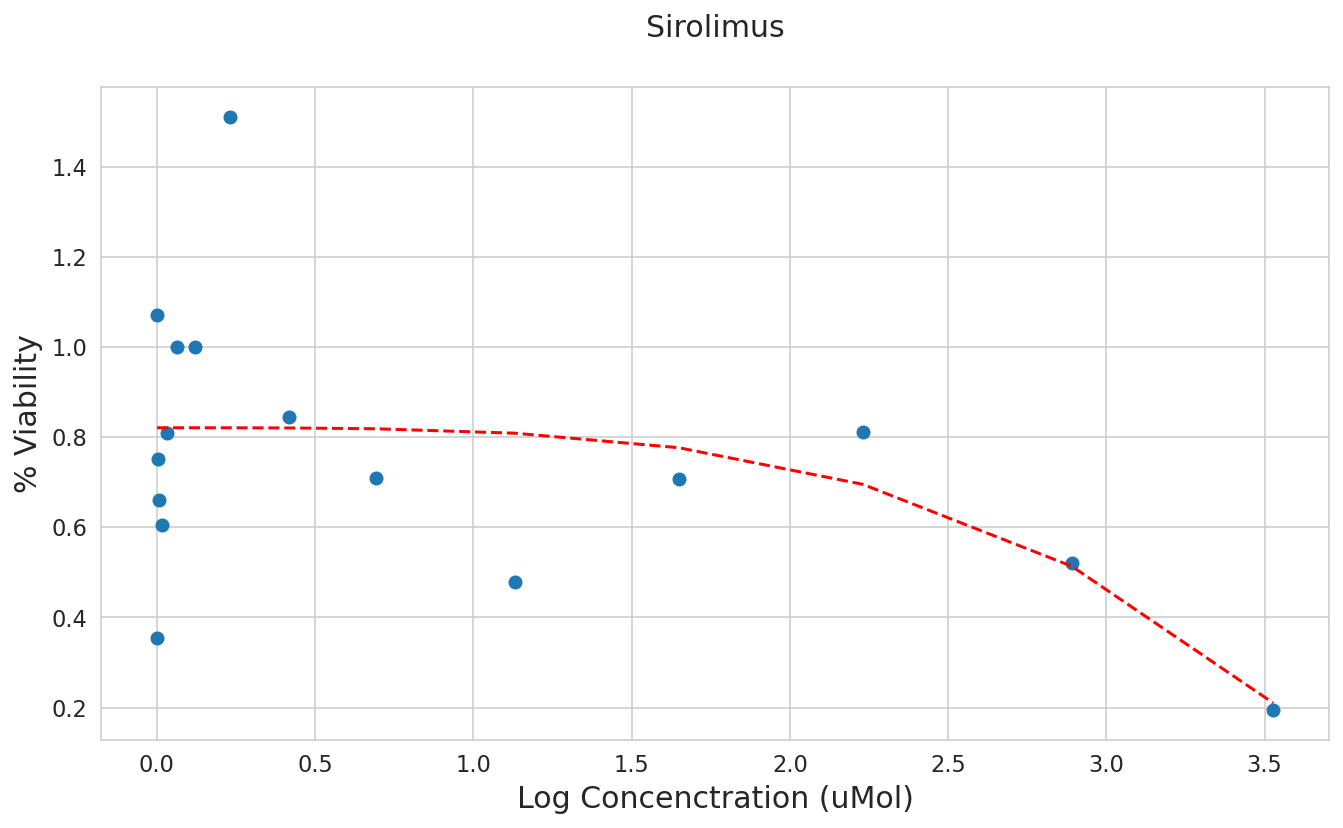

In [172]:
x = meta_val_cpd[meta_val_cpd['cpd_name']=='sirolimus']['log_cpd_conc'].values
y = meta_val_cpd[meta_val_cpd['cpd_name']=='sirolimus']['cpd_pred_pv'].values
popt, pcov = curve_fit(ll4, x, y)
plt.plot(x, y, ".", ms=12)
plt.plot(x, ll4(x, *popt), 'r--')
plt.xlabel('Log Concenctration (uMol)')
plt.ylabel('% Viability')
plt.title('Sirolimus')

### Load Model

In [134]:
ls /scratch/disk2/wconnell/film-gex-data/lightning_logs/13lr-es-van_vanilla_fold_0/checkpoints/

epoch=11.ckpt


In [ ]:
ConditionalNetwork()

In [139]:
model_dir = "/scratch/disk2/wconnell/film-gex-data/lightning_logs/"
film_model = ConditionalNetwork.load_from_checkpoint(os.path.join(model_dir, "13lr-es-film_film_fold_0/checkpoints/epoch=26.ckpt"))
van_model = StandardNetwork.load_from_checkpoint(os.path.join(model_dir, "13lr-es-van_vanilla_fold_0/checkpoints/epoch=11.ckpt"))
film_model.freeze()
van_model.freeze()

In [196]:
# load proceessed data (stdscaled)
inputs, conds, y = dm.val_dataset.tensors

In [141]:
conds_uq = conds[cpd_idx]
inputs_uq = inputs[line_idx]

In [142]:
# film emb
film_inputs_emb = film_model.inputs_emb(inputs_uq)
film_conds_emb = film_model.conds_emb(conds_uq)

## Prediction Evaluation

In [153]:
print(inputs.shape)
print(conds.shape)

torch.Size([116249, 978])
torch.Size([116249, 513])


In [197]:
_, _, _, y_hat_film = film_model(inputs, conds, conds)
y_hat_van = van_model(torch.cat([inputs, conds], axis=1))

In [198]:
preds = pd.DataFrame({'True':y.view(-1),
                     'FiLM Predictions':y_hat_film.view(-1),
                     'Vanilla Predictions':y_hat_van.view(-1)})

Text(0.5, 1.0, 'Fold 1 Prediction Evaluation')

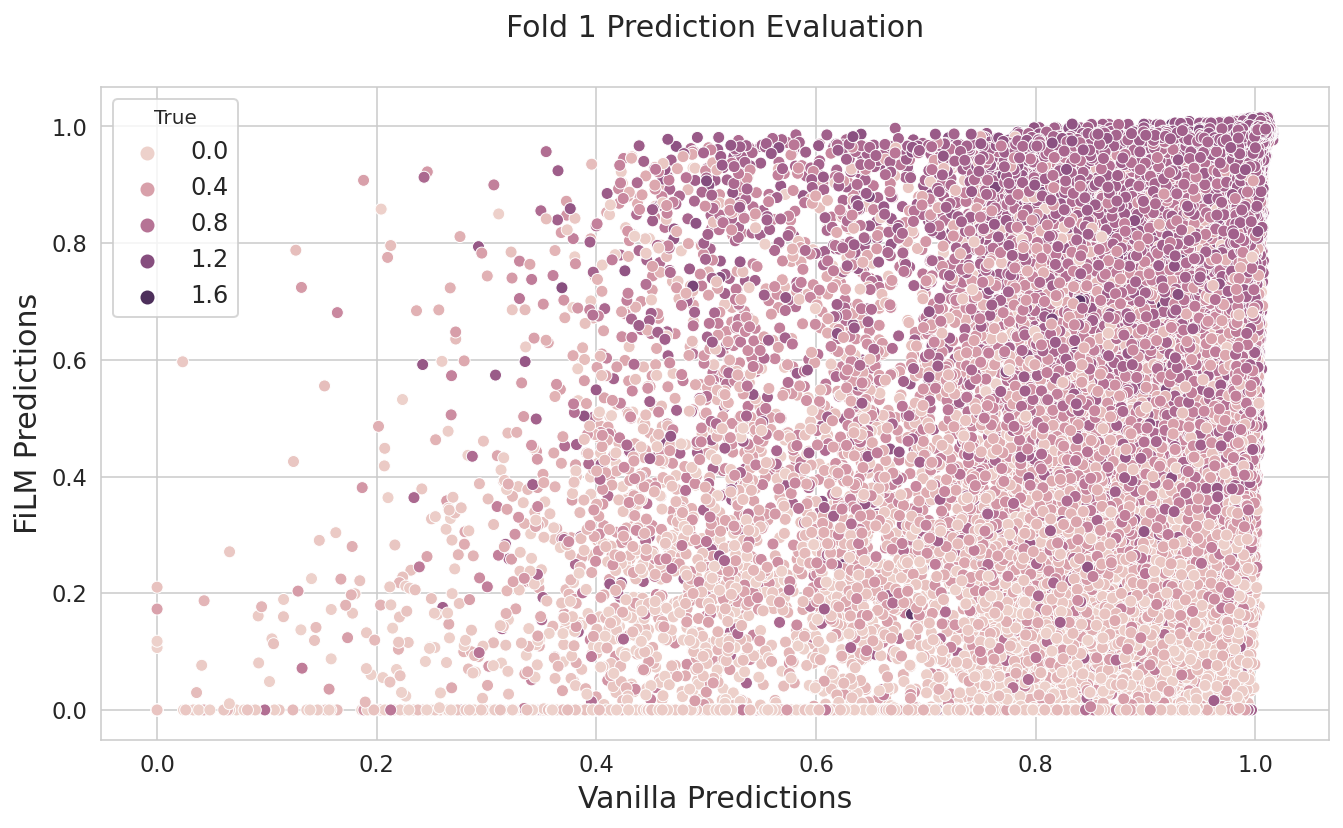

In [205]:
sns.scatterplot(x='Vanilla Predictions', y='FiLM Predictions', hue='True', data=preds)
plt.title('Fold 1 Prediction Evaluation')

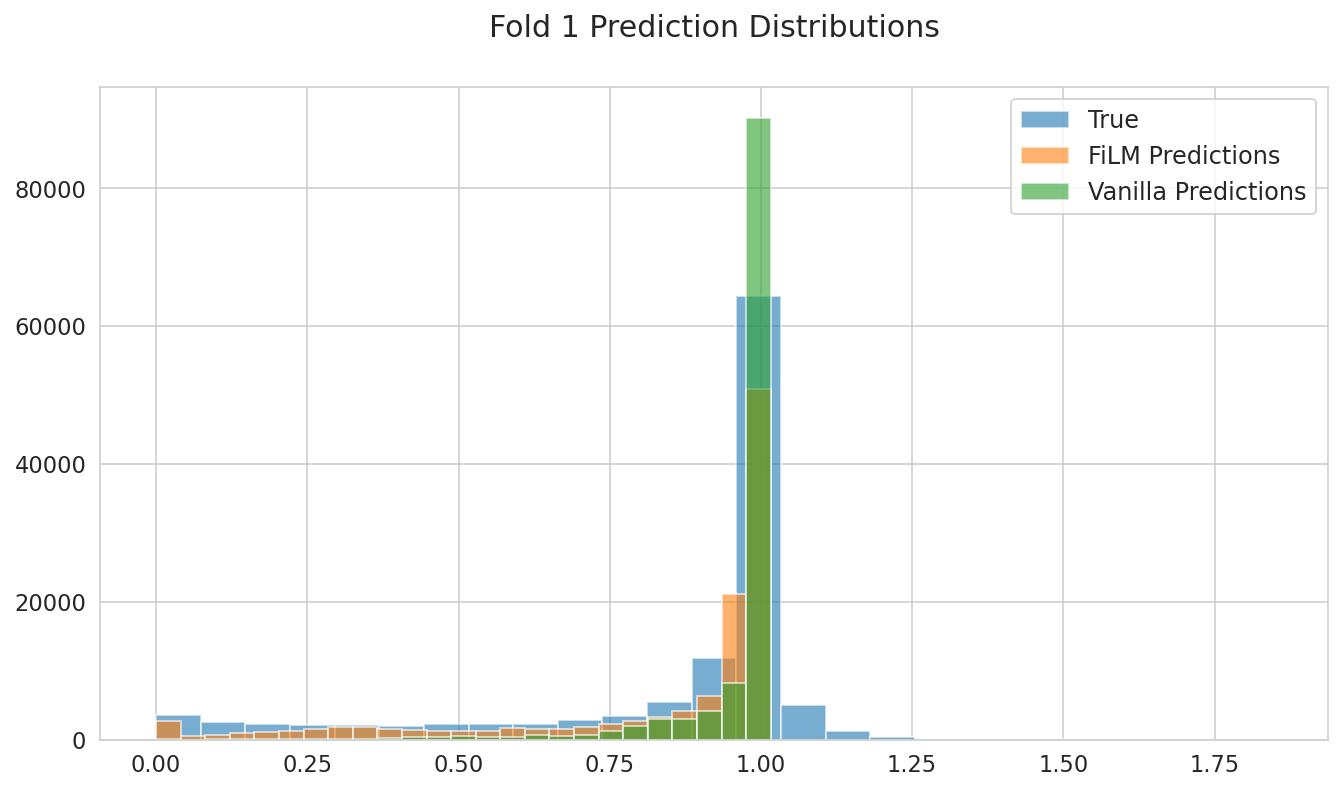

In [206]:
plt.hist(preds['True'], alpha=0.6, label='True', bins=25)
plt.hist(preds['FiLM Predictions'], alpha=0.6, label='FiLM Predictions', bins=25)
plt.hist(preds['Vanilla Predictions'], alpha=0.6, label='Vanilla Predictions', bins=25)
plt.title("Fold 1 Prediction Distributions")
plt.legend()

#### Predict over concentration range

In [41]:
query_idx = np.where(meta_val_cpd['cpd_name']=='erlotinib')[0]

In [42]:
conds_uq[query_idx].shape

torch.Size([16, 513])

## FiLM Parameter Analysis

In [44]:
film_model.film_1.gamma

LinearBlock(
  (block): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [45]:
film1_gamma, film1_beta = film_model.film_1.gamma(film_conds_emb), film_model.film_1.beta(film_conds_emb)
film2_gamma, film2_beta = film_model.film_2.gamma(film_conds_emb), film_model.film_2.beta(film_conds_emb)

In [46]:
from sklearn.manifold import TSNE

### Film 1

In [47]:
# First Film Layer
tsne = TSNE()
film1_tsne = tsne.fit_transform(torch.cat([film1_gamma, film1_beta]).numpy())

film1_params = pd.concat([meta_val_cpd.copy(), meta_val_cpd.copy()])
film1_params['Parameter'] = np.concatenate((np.repeat('gamma', len(film1_gamma)), np.repeat('beta', len(film1_beta))))
film1_params['TSNE_0'] = film1_tsne[:,0]
film1_params['TSNE_1'] = film1_tsne[:,1]

<AxesSubplot:xlabel='TSNE_0', ylabel='TSNE_1'>

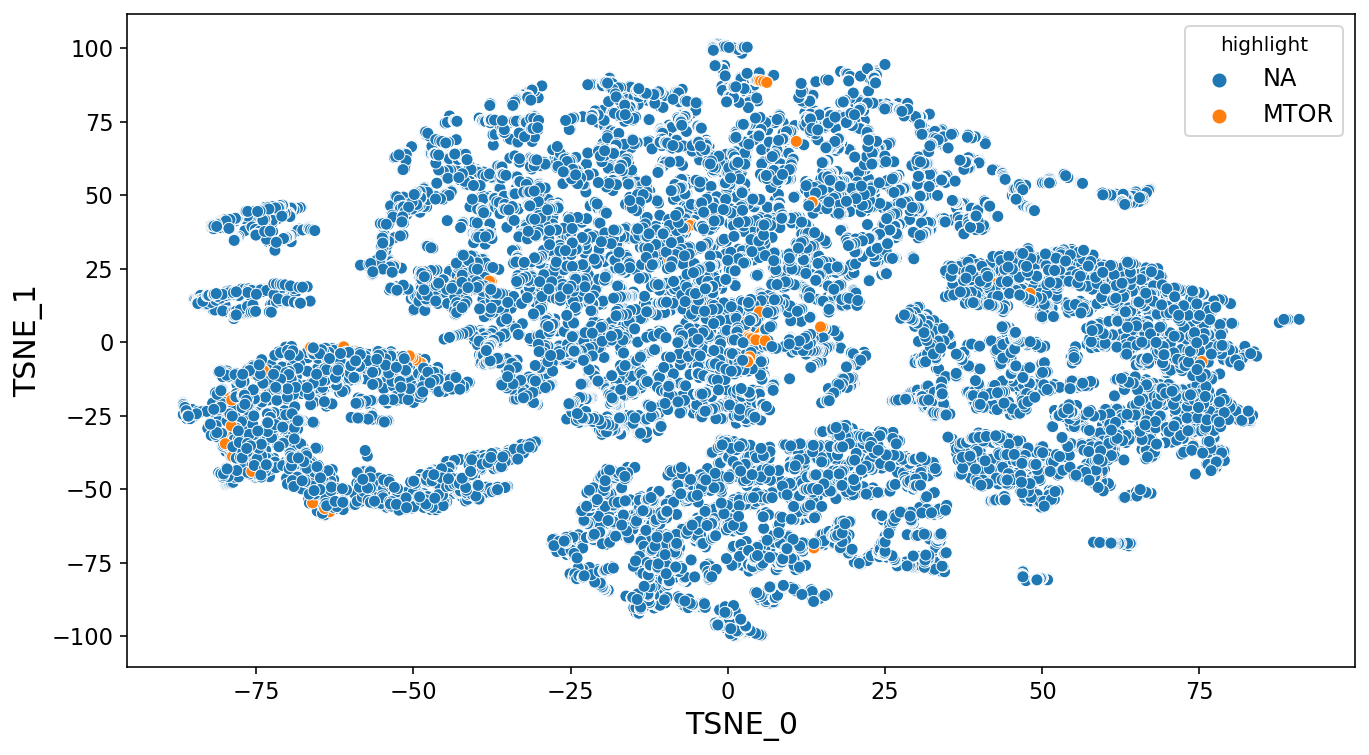

In [48]:
query = 'MTOR'
col = 'gene_symbol_of_protein_target'
film1_params['highlight'] = np.where(film1_params[col]==query, query, 'NA')
sns.scatterplot(x='TSNE_0', y='TSNE_1', hue='highlight', data=film1_params)

<AxesSubplot:xlabel='TSNE_0', ylabel='TSNE_1'>

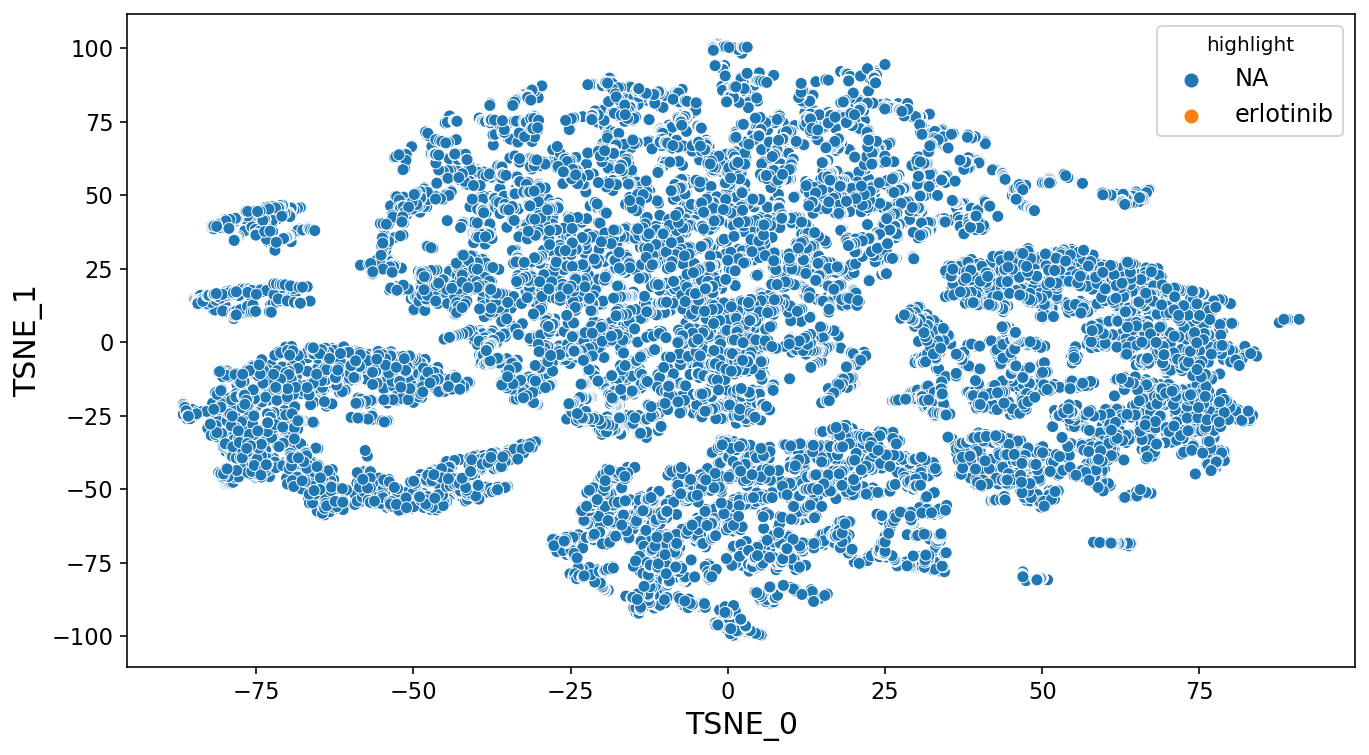

In [49]:
query = 'erlotinib'
col = 'cpd_name'
film1_params['highlight'] = np.where(film1_params[col]==query, query, 'NA')
sns.scatterplot(x='TSNE_0', y='TSNE_1', hue='highlight', data=film1_params)

<AxesSubplot:xlabel='TSNE_0', ylabel='TSNE_1'>

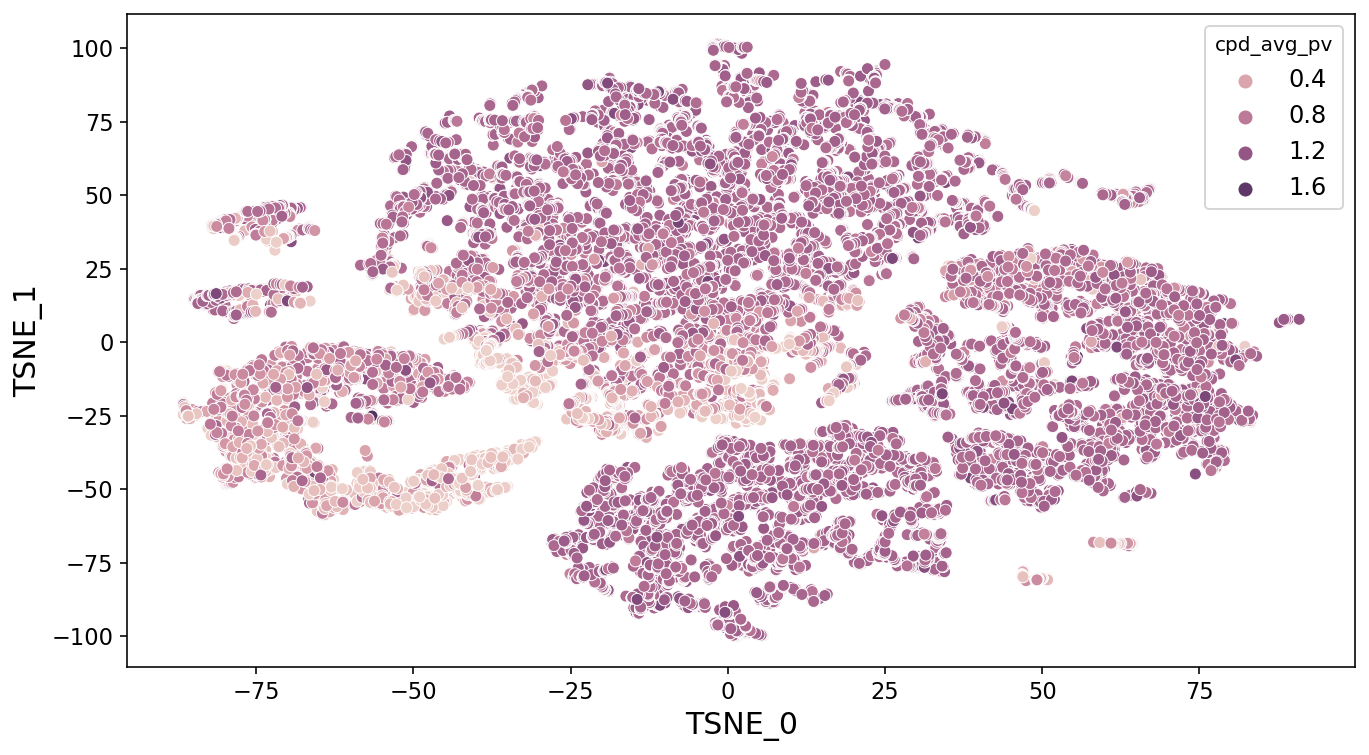

In [50]:
sns.scatterplot(x='TSNE_0', y='TSNE_1', hue='cpd_avg_pv', data=film1_params)

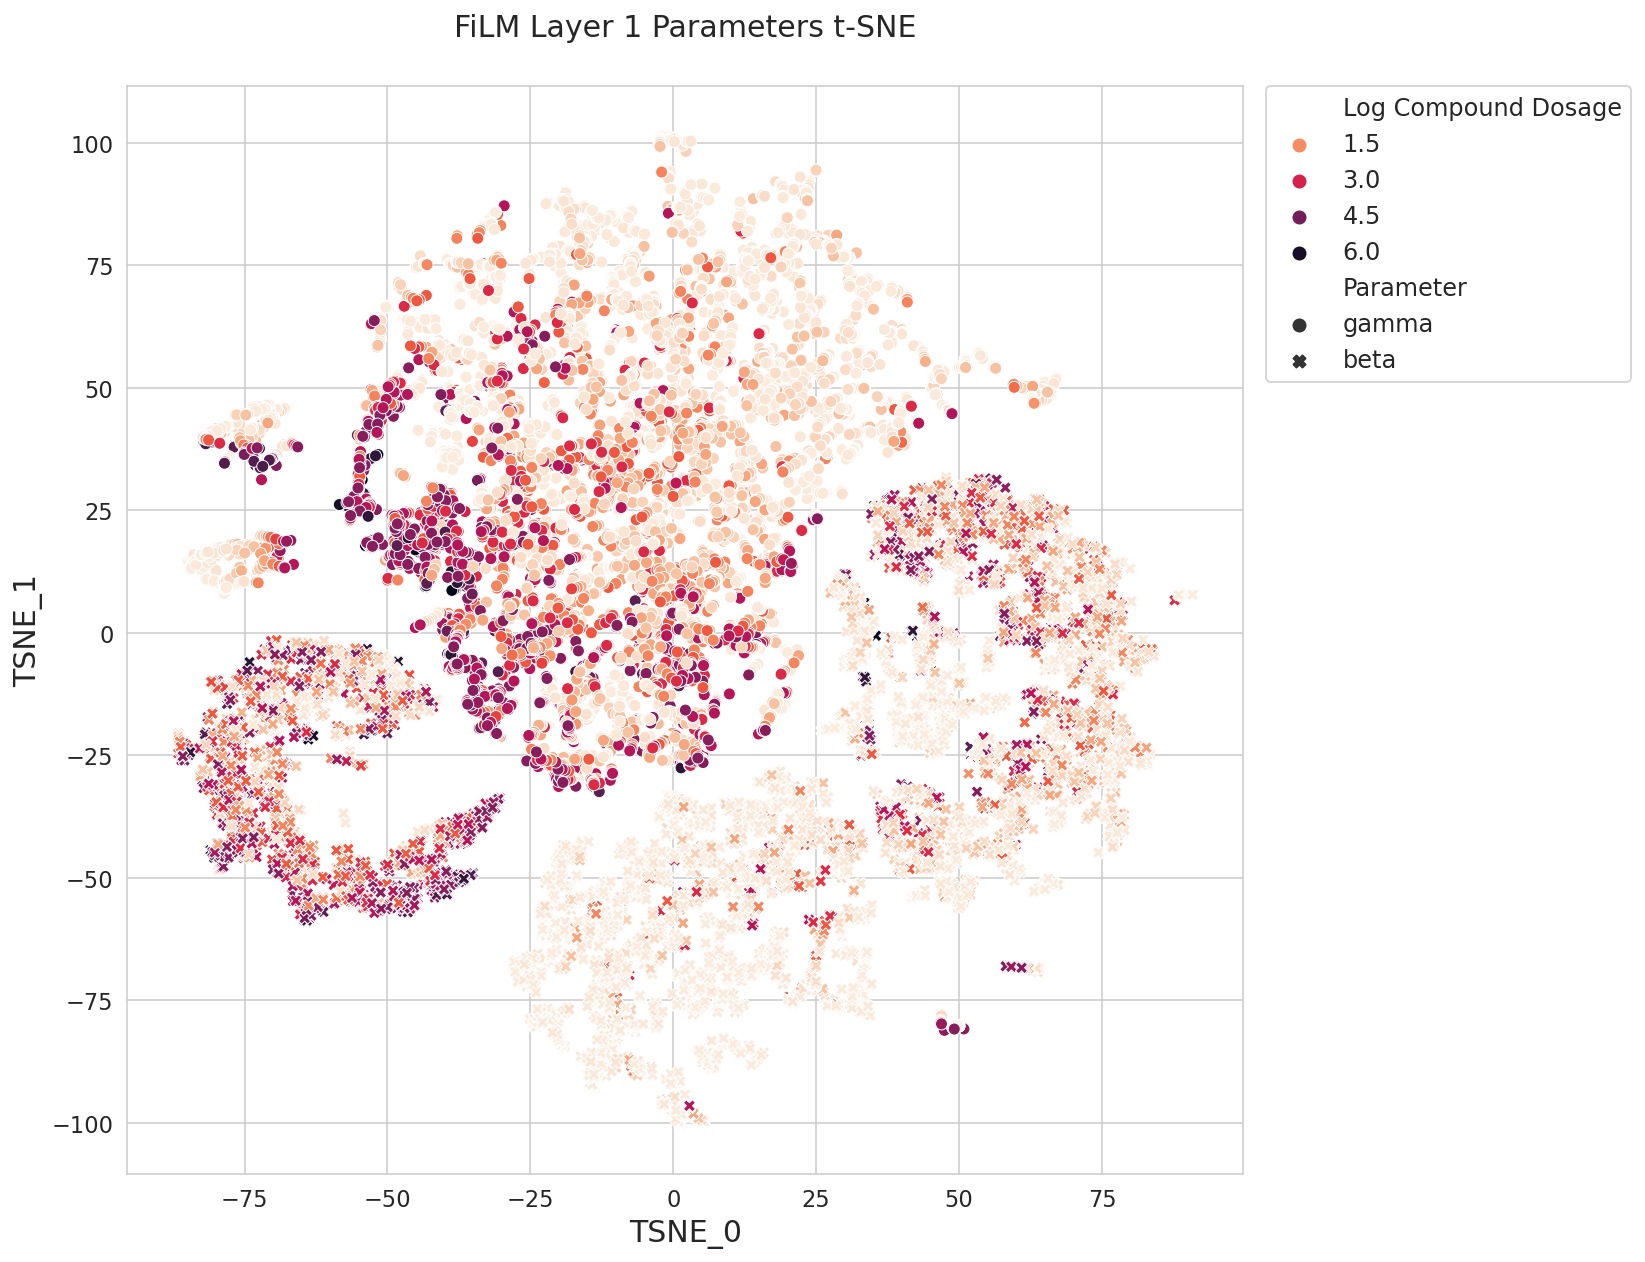

In [178]:
film1_params = film1_params.rename(columns={'log_cpd_conc': 'Log Compound Dosage'})
plt.figure(figsize=(10,10))
g = sns.scatterplot(x='TSNE_0', y='TSNE_1', hue='Log Compound Dosage', style='Parameter', palette='rocket_r', data=film1_params)
g.set_title('FiLM Layer 1 Parameters t-SNE')
g.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show()

### Logs

In [52]:
from tensorboard.backend.event_processing import event_accumulator

In [53]:
def ea_to_df(path, metric):
    for i in os.listdir(path):
        if os.path.isfile(os.path.join(path,i)) and 'events.out.tfevents' in i:
            #print(os.path.join(path, i))
            ea = event_accumulator.EventAccumulator(os.path.join(path, i))
            ea.Reload()
            _, step, value = zip(*ea.Scalars(metric))
            name, model, _, fold = os.path.split(path)[1].split("_")
            df = pd.DataFrame({'name': np.repeat(name, len(step)),
                               'model': np.repeat(model, len(step)),
                               'fold': np.repeat(fold, len(step)),
                               'epoch': np.arange(1, len(step)+1),
                               'step': step,
                               metric: value})
    return df

In [84]:
def plt_metric(names, metric, bound, **kwargs):
    path = Path("/scratch/disk2/wconnell/film-gex-data/lightning_logs/")
    df = pd.concat([ea_to_df(path.joinpath(p), metric) for p in os.listdir(path)])
    df = df[df['name'].isin(names.keys())]
    # averages
    df_avg = df.groupby(['name', 'epoch']).mean().reset_index()
    if bound=='min':
        df_best = df_avg.groupby(['name']).min()
    elif bound=='max':
        df_best = df_avg.groupby(['name']).max()
    # plot
    g = sns.lineplot(x='epoch', y=metric, hue='name', data=df, legend=True, ci=95)
    # legend
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.legend(loc=kwargs['loc'])
    for i,txt in enumerate(g.legend_.texts):
        val = df_best.loc[txt.get_text()][metric]
        g.legend_.texts[i].set_text(f"{names[txt.get_text()]} = {val:.4f}")
    plt.xlabel('Epoch')
    g.set_xticks(df['epoch'].unique())
    g.set_xticklabels(df['epoch'].unique())
    #g.set_yticks(kwargs['yticks'])
    plt.ylim(kwargs['ylim'])
    plt.ylabel(kwargs['ylabel'])
    g.set_title(f"{kwargs['title']}, 5-Fold CV")
    plt.show(g)

In [184]:
#names = ['25eps-id-id', '25eps-vanilla', '25eps-shift', '25eps-scale', '25eps-film']
names = ['13lr-es-id', '13lr-es-van', '13lr-es-shift', '13lr-es-scale', '13lr-es-film']
models = ['ID', 'Vanilla', 'Shift', 'Scale', 'FiLM']
names = dict(zip(names, models))
names

{'13lr-es-id': 'ID',
 '13lr-es-van': 'Vanilla',
 '13lr-es-shift': 'Shift',
 '13lr-es-scale': 'Scale',
 '13lr-es-film': 'FiLM'}

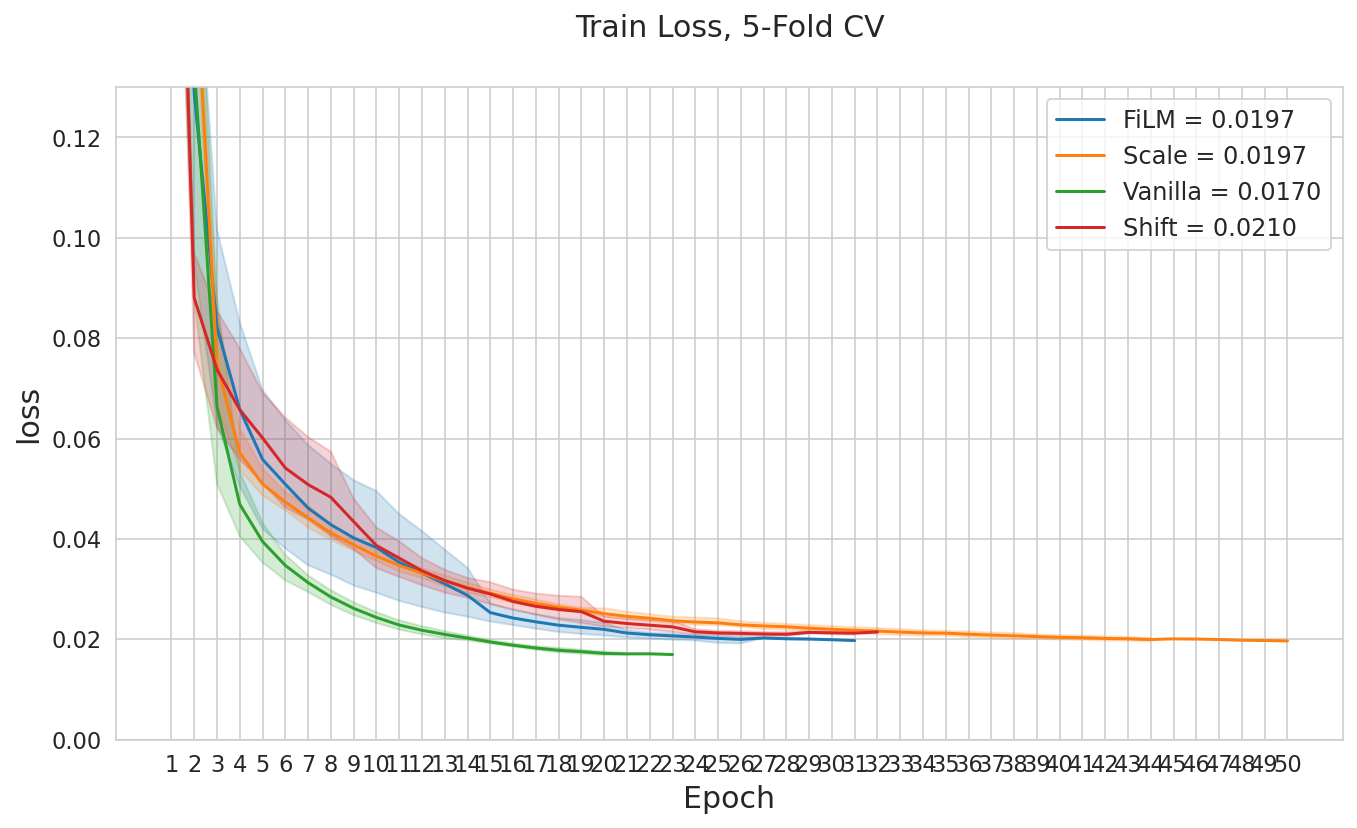

In [85]:
plt_metric(names, 'train_loss_epoch', 'min', ylim=(0,0.13), title='Train Loss', ylabel='loss', loc="upper right")

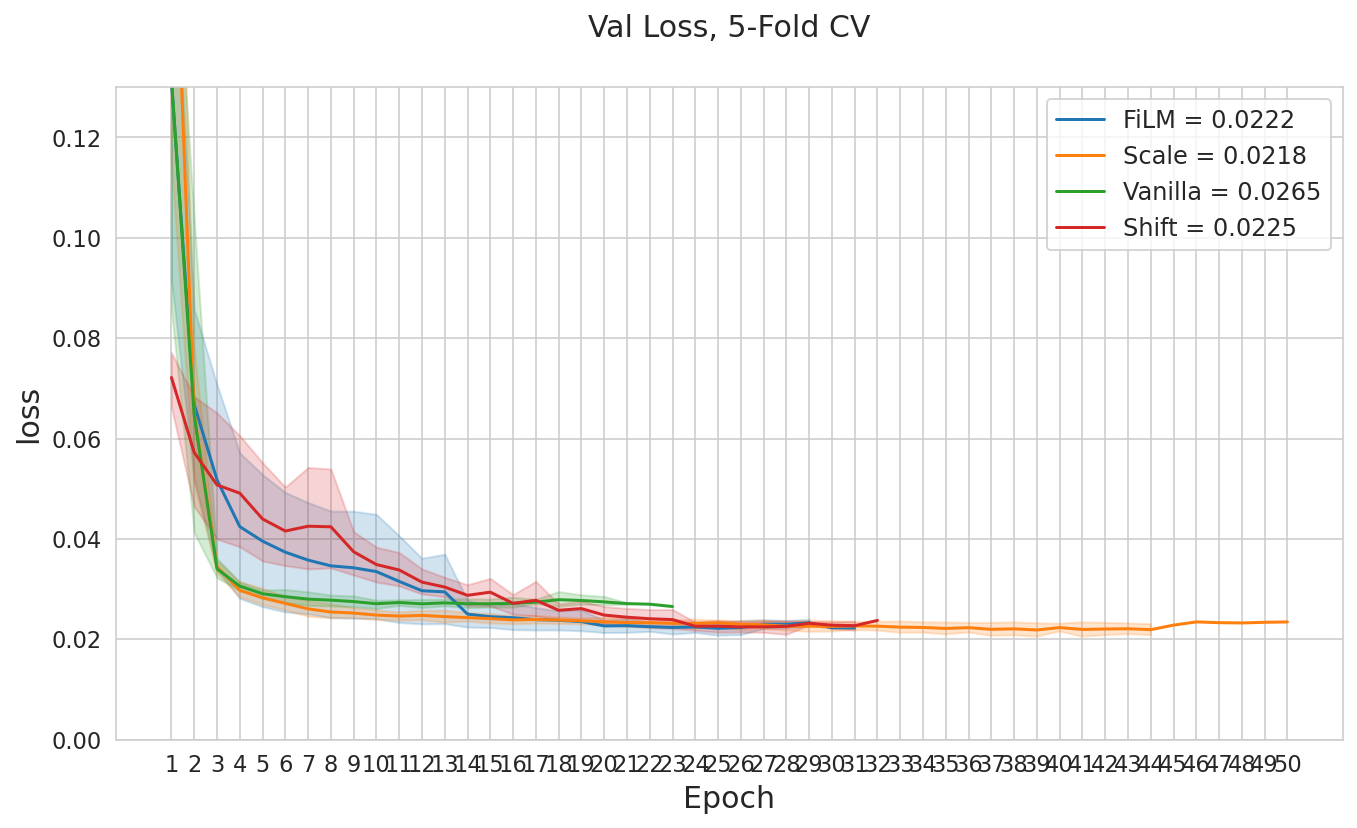

In [86]:
plt_metric(names, 'val_loss', 'min', ylim=(0,0.13), title='Val Loss', ylabel='loss', loc="upper right")

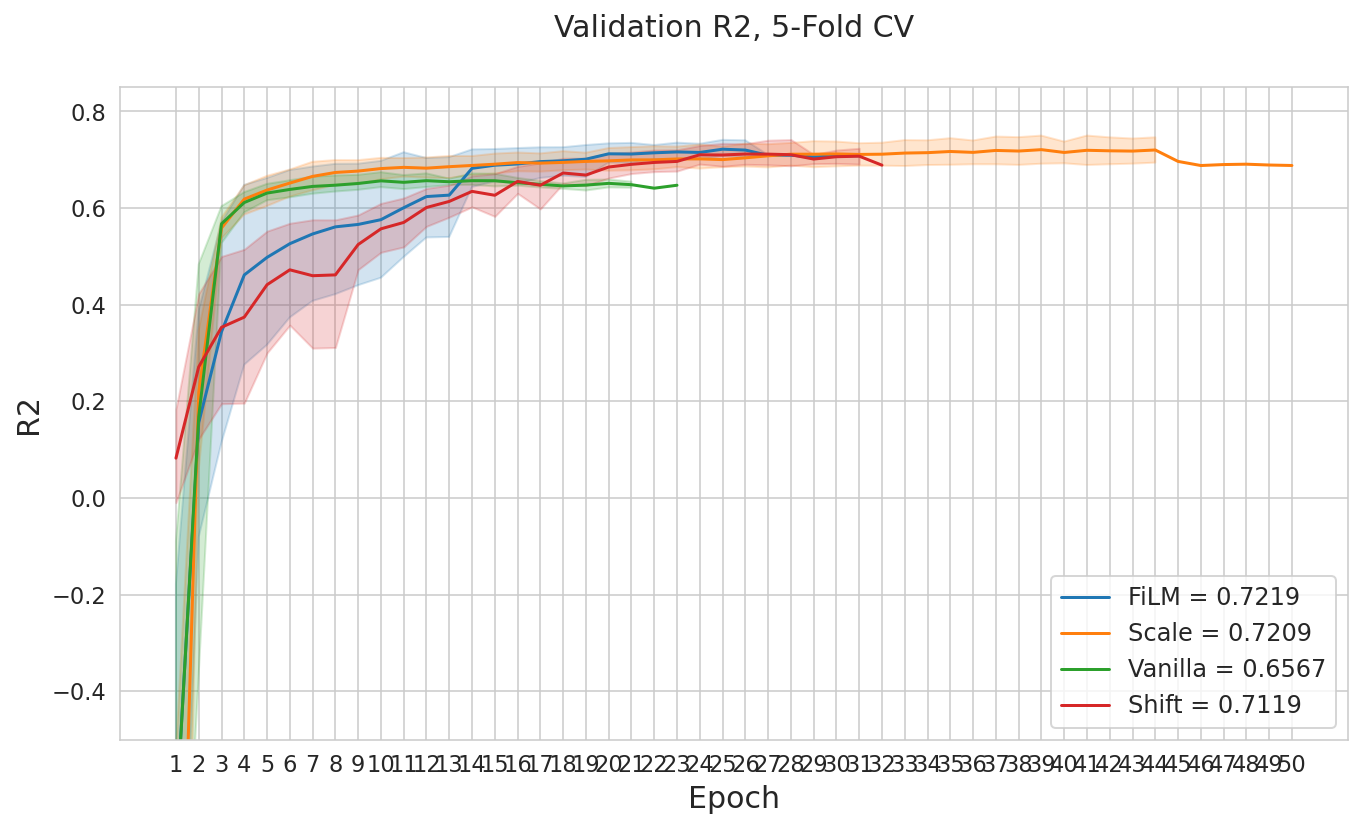

In [87]:
sns.set_style("whitegrid")
plt_metric(names, 'val_r2', 'max', ylabel='R2', ylim=(-0.50,0.85), yticks=np.arange(-0.5, 0.85, .1), title='Validation R2', loc='lower right')

In [185]:
metric = 'val_r2'
path = Path("/scratch/disk2/wconnell/film-gex-data/lightning_logs/")
df = pd.concat([ea_to_df(path.joinpath(p), metric) for p in os.listdir(path)])
df = df[df['name'].isin(names.keys())]

In [186]:
from scipy.stats import sem

In [187]:
# maximum R2 of each fold for each model; average and std error
df_max = df.groupby(['name', 'fold'])[metric].max().reset_index()
df_max_avg = df_max.groupby(['name']).mean()
for name in df_max_avg.index.unique():
    stderr = sem(df_max[df_max['name']==name][metric])
    max_avg = df_max_avg.loc[name, metric]
    print(f"{name}, max_avg={max_avg*100:.2F}, error={stderr*100:.2f}")

13lr-es-film, max_avg=71.90, error=0.98
13lr-es-id, max_avg=-0.57, error=1.70
13lr-es-scale, max_avg=71.05, error=1.04
13lr-es-shift, max_avg=70.52, error=1.44
13lr-es-van, max_avg=66.29, error=0.75
